## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import Tensor as tensor
from dlc_practical_prologue import generate_pair_sets

from torchsummary import summary

import matplotlib.pyplot as plt


## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [5]:
N = 1000
train_input, train_target, train_class, test_input, test_target, test_class = generate_pair_sets(N)

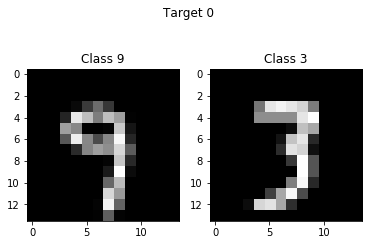

In [6]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Class {train_class[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Class {train_class[0][1].item()}")
fig.suptitle(f"Target {train_target[0].item()}")

plt.show()

In [41]:
# Data loaders
batch_size = 20
train_loader = DataLoader(list(zip(train_input, train_target, train_class)), batch_size)
test_loader = DataLoader(list(zip(test_input, test_target, test_class)), batch_size)

## Model

In [42]:
nb_channels = 2 # input channel
nb_digits = 10 # number of digit classes
nb_class = 2 # number of output classes

cross_entropy = nn.CrossEntropyLoss()
mse = nn.MSELoss()

###  CNN model: No Auxiliary Loss

In [43]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3) 
        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(6, 16, 3) 
        self.fc1 = nn.Linear(16 * 2 * 2, 50) 
        self.fc2 = nn.Linear(50, output_channels) #output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### CNN model: With Auxiliary Loss

In [44]:
class CNN_AL(nn.Module):
    def __init__(self, input_channels, output_channels, output_channels_aux):
        super().__init__()
        self.output_channels_aux = output_channels_aux
        self.conv1 = nn.Conv2d(input_channels, 6, 3) 
        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(6, 16, 3) 
        self.fc1 = nn.Linear(16 * 2 * 2, 50)
        self.fc1_aux = nn.Linear(16 * 2, 50) 
        self.fc2 = nn.Linear(50, output_channels) #output
        self.fc2_aux = nn.Linear(50, output_channels_aux)#output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x_aux = x
        x = x.view(-1, 16 * 2 * 2)
        x_aux = x_aux.view(-1, 16 * 2)
        x = F.relu(self.fc1(x))
        x_aux = F.relu(self.fc1_aux(x_aux))
        x = self.fc2(x)
        x_aux = self.fc2_aux(x_aux)
        return x, x_aux.reshape(2,-1,self.output_channels_aux)

        
    def predict(self, output_class):
        _, predicted_class = torch.max(output_class, 1)
        return predicted_class

In [45]:
CNN_model = CNN(nb_channels, nb_class)
summary(CNN_model, input_size=(2, 14, 14))
CNN_AL_model = CNN_AL(nb_channels, nb_class, nb_digits)
summary(CNN_AL_model, input_size=(2, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
Total params: 4,346
Trainable params: 4,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 1

## Training

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [60]:
def calc_accuracy(model, data_loader, AL):
    correct = 0
    correct_digit = 0
    total = 0
    
    for (image, target, digit_target) in data_loader:

        total += len(target)
        if not AL:
            output = model(image)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            return correct / total
        else:
            output, digit = model(image)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            _, pred_digit = torch.max(digit, 2)
            correct_digit += (pred_digit[0,:] == digit_target[:,0]).sum().item()
            correct_digit += (pred_digit[1,:] == digit_target[:,1]).sum().item()
            return correct / total, correct_digit / total


In [61]:
def train(train_data_loader, test_data_loader,
          model, optimizer, criterion,
          epochs=10, test_every=10, AL = False):
    
    losses = []
    accuracy_train = []
    accuracy_test = []
    accuracy_train_digit = []
    accuracy_test_digit = []
    
    for epoch in range(epochs):
        step = 0
        
        for (image, target, digit_target) in train_data_loader:
            step += 1

            optimizer.zero_grad()
            if AL:
                output, digit = model(image)
                loss = criterion(output, target)
                loss += criterion(tensor.float(digit[0,:]), digit_target[:,0])
                loss += criterion(tensor.float(digit[1,:]), digit_target[:,1])

            else:
                output = model(image)
                loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if step % test_every == 0:
                losses.append(loss)
                
                model.eval()
                with torch.no_grad():
                    accuracy_train_data = calc_accuracy(model, train_data_loader, AL)
                    accuracy_test_data = calc_accuracy(model, test_data_loader, AL)
                    
                    if AL:
                        acc_train, acc_train_digit = accuracy_train_data
                        acc_test, acc_test_digit = accuracy_test_data
                        
                        accuracy_train_digit.append(acc_train_digit)
                        accuracy_test_digit.append(acc_test_digit)
                    else:
                        acc_train = accuracy_train_data
                        acc_test = accuracy_test_data
                        
                    accuracy_train.append(acc_train)
                    accuracy_test.append(acc_test)

        print(f"Epoch {epoch + 1}/{epochs}, Step {step}, loss {losses[-1]:0.4f},",
              f"train accuracy {accuracy_train[-1]}, test accuracy {accuracy_test[-1]}",
              f"train accuracy digit {accuracy_train_digit[-1]}, test accuracy digit {accuracy_test_digit[-1]}"
              if accuracy_train_digit else "")
        
    return accuracy_train, accuracy_test, losses

In [101]:
reg = 0.8
lr = 0.0003 # Add learning rate decay
epochs = 25
net = CNN_AL(nb_channels, nb_class, nb_digits)
net2 = CNN(nb_channels, nb_class)

train_info = train(train_loader, test_loader,
             model=net,
             optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
             criterion=cross_entropy,
             epochs=epochs, test_every=2, AL = True)
# train_info = train(train_loader, test_loader,
#              model=net2,
#              optimizer=optim.Adam(net2.parameters(), lr=lr, weight_decay=reg), 
#              criterion=cross_entropy,
#              epochs=epochs, test_every=2, AL = False)

Epoch 1/25, Step 50, loss 9.8813, train accuracy 0.45, test accuracy 0.5 train accuracy digit 0.25, test accuracy digit 0.15
Epoch 2/25, Step 50, loss 6.9585, train accuracy 0.4, test accuracy 0.55 train accuracy digit 0.2, test accuracy digit 0.1
Epoch 3/25, Step 50, loss 6.2650, train accuracy 0.3, test accuracy 0.55 train accuracy digit 0.2, test accuracy digit 0.1
Epoch 4/25, Step 50, loss 5.8612, train accuracy 0.3, test accuracy 0.65 train accuracy digit 0.25, test accuracy digit 0.1
Epoch 5/25, Step 50, loss 5.6052, train accuracy 0.25, test accuracy 0.7 train accuracy digit 0.3, test accuracy digit 0.15
Epoch 6/25, Step 50, loss 5.4464, train accuracy 0.3, test accuracy 0.75 train accuracy digit 0.3, test accuracy digit 0.2
Epoch 7/25, Step 50, loss 5.3170, train accuracy 0.3, test accuracy 0.75 train accuracy digit 0.3, test accuracy digit 0.2
Epoch 8/25, Step 50, loss 5.2454, train accuracy 0.35, test accuracy 0.75 train accuracy digit 0.3, test accuracy digit 0.2
Epoch 9/25,

In [98]:
accuracy_train, accuracy_test, losses = train_info

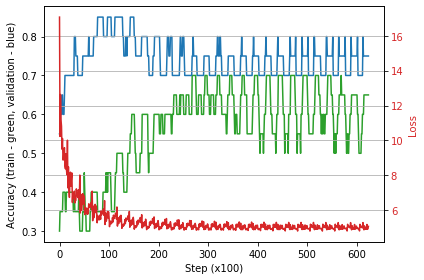

In [99]:
fig, ax1 = plt.subplots()

color_tr = 'tab:green'
color_val = 'tab:blue'
ax1.set_xlabel("Step (x100)")
ax1.set_ylabel("Accuracy (train - green, validation - blue)")
ax1.plot(range(len(accuracy_train)), accuracy_train, color=color_tr)
ax1.plot(range(len(accuracy_test)), accuracy_test, color=color_val)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_loss = 'tab:red'
ax2.set_ylabel("Loss", color=color_loss)  # we already handled the x-label with ax1
ax2.plot(range(len(losses)), losses, color=color_loss)
ax2.tick_params(axis='y', labelcolor=color_loss)

fig.tight_layout()
plt.grid()
plt.show()

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.